## Data Preprocessing Model
* Identifying Missing data, Columns to drop
* Map Rating to Sentiment Classification
* Creating Cleaned Dataset

Import Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import os



Download NLTK Resources

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bshanmugam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [7]:

file_path = "data/amazon_reviews_data.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username","reviews.didPurchase"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['full_review']).sum()}")
df = df.drop_duplicates(subset=['full_review'])
print(f"Shape after dropping duplicates: {df.shape}")
df.columns

Original shape: (33332, 25)
After removing missing: (33332, 26)
After removing columns: (33332, 10)
Number of duplicate reviews: 13269
Shape after dropping duplicates: (20063, 10)


/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_19389/1789562783.py:2: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'full_review'],
      dtype='object')

Visualize Ratings Distribution

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_19389/2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


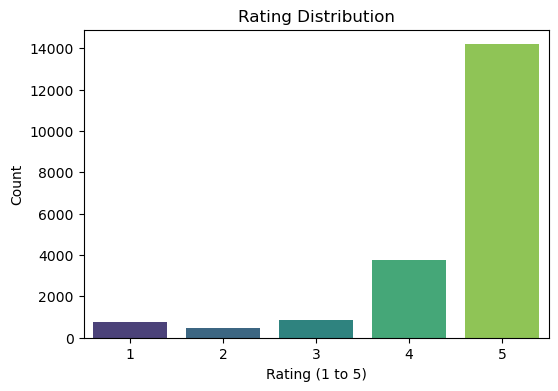

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_19389/759677541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


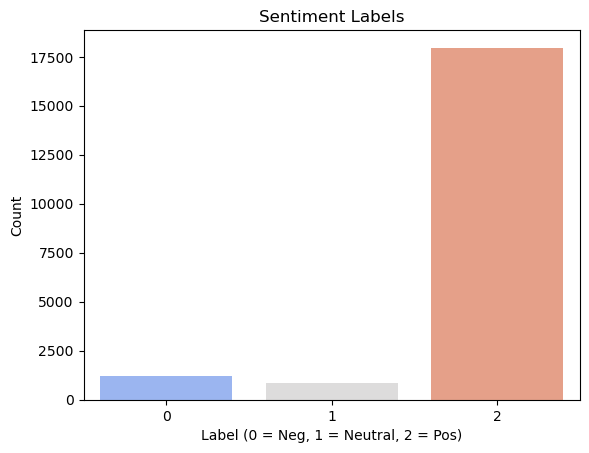

In [9]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()

Clean Text (Simple + Stopwords + Stemming)

In [10]:
stop_words = set(stopwords.words('english'))


def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-z\s]', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
   
    return ' '.join(tokens)
   


df['clean_text'] = df['full_review'].apply(simple_clean_text)
df[['full_review', 'clean_text']].sample(10)





,full_review,clean_text
11187,Last just as long or longer than the name bran...,last just as long or longer than the name bran...
10585,Great quality for a good price! - Quality prod...,great quality for a good price quality product...
17120,Sturdy - Well made. Seems sturdy. Multiple com...,sturdy well made seems sturdy multiple compart...
10950,I love AmazonBasics. With all the electronics ...,i love amazonbasics with all the electronics d...
3825,Great e-reader. - Great e-reader. Easy to down...,great ereader great ereader easy to download b...
11532,not as expected - I bought these because of al...,not as expected i bought these because of all ...
25353,Great tablet for my son. - My son has enjoyed ...,great tablet for my son my son has enjoyed his...
8506,Five Stars - They're batteries. Not much to fu...,five stars theyre batteries not much to fuss a...
12191,Surprisingly as good as the top makes - Nicely...,surprisingly as good as the top makes nicely p...
21314,I love it - I love the amazon tablet very much...,i love it i love the amazon tablet very much a...


Dropping full_reviews column

In [11]:
df.drop(columns='full_review', inplace=True, errors='ignore')
df.columns

Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'sourceURLs', 'label',
       'clean_text'],
      dtype='object')

Top Common Words per Sentiment Class

In [12]:
from collections import Counter
import pandas as pd

def get_top_n_words(text_series, n=15):
    # Ensure we are dealing with strings
    all_words = ' '.join(text_series.dropna().astype(str)).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

# Loop through each sentiment label and show top words
for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'], n=15)
    print(top_words)



🔹 Top words for Negative reviews:
         word  count
0         the   2007
1           i   1724
2           a   1258
3   batteries   1230
4          to   1175
5         and   1158
6         not    849
7          of    831
8          in    795
9       these    733
10         it    699
11        for    679
12       they    573
13         my    529
14       have    493

🔹 Top words for Neutral reviews:
         word  count
0         the   1270
1           i    872
2          to    833
3           a    717
4         for    708
5          it    632
6         and    611
7         not    522
8         but    491
9          as    450
10         is    424
11         of    392
12  batteries    364
13       good    324
14       they    321

🔹 Top words for Positive reviews:
         word  count
0         the  19873
1         and  15158
2         for  13613
3           i  13361
4          to  13139
5           a  12002
6       great  11623
7          it  10860
8          is   7556
9          my 

Word Cloud per Sentiment Class

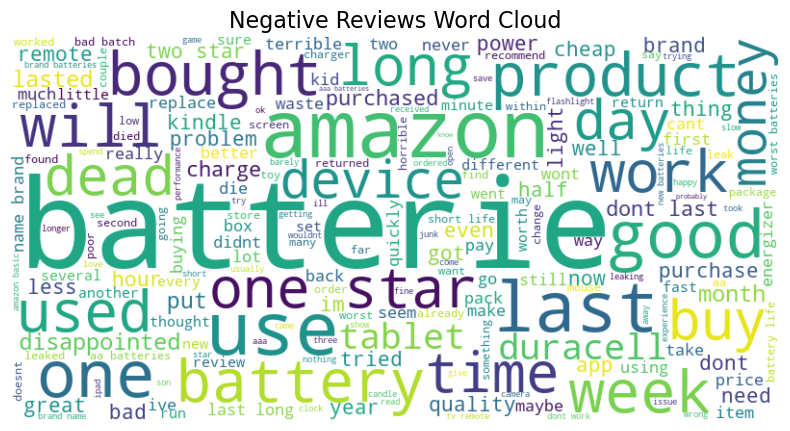

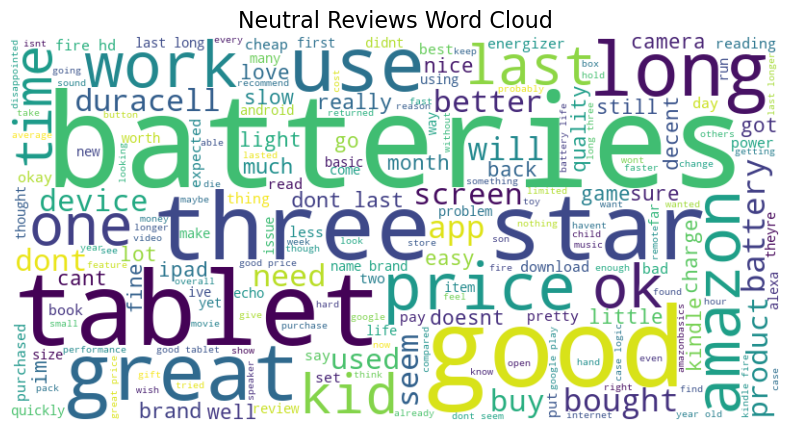

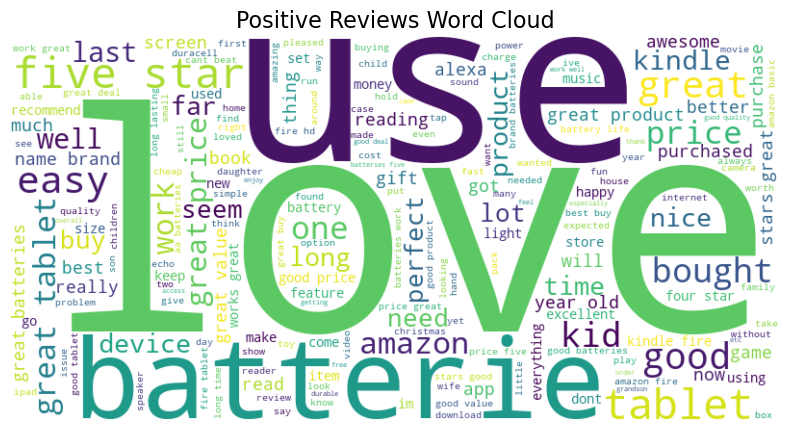

In [13]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [14]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
